In [268]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from keras.layers import Dense
from keras.models import Sequential
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
from tensorflow.keras.optimizers import Adam
import tensorflow_addons as tfa

In [269]:
listings_df = pd.read_csv('../data/processed/processed_listings.csv').dropna()
len(listings_df)

46587

In [270]:
listings_df.head()

,subtype,style,living_area,lot_dimensions,bedrooms,bathrooms,levels,location,listing_year,listing_date,year_of_construction,price
0,2 Storey,2 storey,1191,4076,3,1,2,Beauport,2020,2020-12-01,2004,332500
1,Bungalow,Open area,1261,9500,2,1,1,Portneuf,2021,2021-12-01,1957,265000
2,Townhouse,Unknown,1645,1360,3,1,3,Châteauguay,2021,2021-11-01,2006,612000
3,Bi-generation,Link,2024,17000,4,3,1,Stoneham,2021,2021-12-01,2019,526500
4,Semi-detached,2 storey,2400,4471,4,2,2,Gatineau,2021,2021-12-01,1989,360000


## Correlation Heat Map

In [271]:
sns.set_theme(style="white")

def plot_corr_map(df):
    # Compute the correlation matrix
    corr = df.corr()

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(8, 6))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

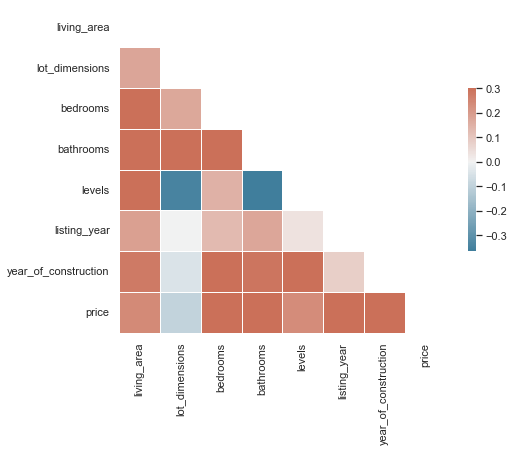

In [272]:
plot_corr_map(listings_df)

## Choosing columns

In [273]:
ordinal_cols = ['location', 'listing_year', 'year_of_construction', 'subtype']
one_hot_cols = []
numerical_cols = ['living_area', 'lot_dimensions', 'bedrooms', 'bathrooms', 'levels']
target_col = ['price']

In [274]:
listings_df = listings_df[ordinal_cols + one_hot_cols + numerical_cols + target_col]
listings_df.head()

,location,listing_year,year_of_construction,subtype,living_area,lot_dimensions,bedrooms,bathrooms,levels,price
0,Beauport,2020,2004,2 Storey,1191,4076,3,1,2,332500
1,Portneuf,2021,1957,Bungalow,1261,9500,2,1,1,265000
2,Châteauguay,2021,2006,Townhouse,1645,1360,3,1,3,612000
3,Stoneham,2021,2019,Bi-generation,2024,17000,4,3,1,526500
4,Gatineau,2021,1989,Semi-detached,2400,4471,4,2,2,360000


## One Hot Encoding

In [275]:
def oh_encode(df_line, col, new_col, val):
    if df_line[col] == val:
        return df_line[new_col] + 1
    else:
        return df_line[new_col]

for col in one_hot_cols:
    for val in listings_df[col].unique():   
        new_col = str(val) + '_' + col
        listings_df[new_col] = 0
        listings_df[new_col] = listings_df.apply(oh_encode, args=(col, new_col, val), axis=1)

    listings_df = listings_df.drop(columns=[col])

In [276]:
listings_df.head()

,location,listing_year,year_of_construction,subtype,living_area,lot_dimensions,bedrooms,bathrooms,levels,price
0,Beauport,2020,2004,2 Storey,1191,4076,3,1,2,332500
1,Portneuf,2021,1957,Bungalow,1261,9500,2,1,1,265000
2,Châteauguay,2021,2006,Townhouse,1645,1360,3,1,3,612000
3,Stoneham,2021,2019,Bi-generation,2024,17000,4,3,1,526500
4,Gatineau,2021,1989,Semi-detached,2400,4471,4,2,2,360000


## Spliting Data

In [277]:
y = listings_df[target_col]
X = listings_df.drop(columns=target_col)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

## Ordinal Encoding

In [278]:
ordinal_encoders = {}

for col in ordinal_cols:
    ordinal_encoders[col] = OrdinalEncoder()
    ordinal_encoders[col].fit(listings_df[[col]])
    X_train[col] = ordinal_encoders[col].transform(X_train[[col]])
    X_test[col] = ordinal_encoders[col].transform(X_test[[col]])

X_train.head()

,location,listing_year,year_of_construction,subtype,living_area,lot_dimensions,bedrooms,bathrooms,levels
2845,5.0,16.0,125.0,1.0,2770,40036,4,3,2
17059,6.0,18.0,95.0,2.0,1267,10100,4,2,1
5083,5.0,14.0,121.0,1.0,1500,4843,3,2,2
5459,5.0,13.0,115.0,6.0,812,3967,3,1,1
32732,5.0,18.0,109.0,6.0,2400,4471,4,2,2


## Scaling

In [279]:
scaled_cols = numerical_cols

In [280]:
scalers = {}

for col in scaled_cols:
    scalers[col] = MinMaxScaler()
    X_train[col] = scalers[col].fit_transform(X_train[[col]])
    X_test[col] = scalers[col].transform(X_test[[col]])

In [281]:
scale_target = True

if scale_target:
    target_scaler = MinMaxScaler()

    y_train = target_scaler.fit_transform(y_train)
    y_test = target_scaler.fit_transform(y_test)

X_train.head()

,location,listing_year,year_of_construction,subtype,living_area,lot_dimensions,bedrooms,bathrooms,levels
2845,5.0,16.0,125.0,1.0,0.652274,0.497289,0.6,0.666667,0.5
17059,6.0,18.0,95.0,2.0,0.219632,0.120674,0.6,0.333333,0.0
5083,5.0,14.0,121.0,1.0,0.286701,0.054537,0.4,0.333333,0.5
5459,5.0,13.0,115.0,6.0,0.088659,0.043517,0.4,0.000000,0.0
32732,5.0,18.0,109.0,6.0,0.545769,0.049857,0.6,0.333333,0.5


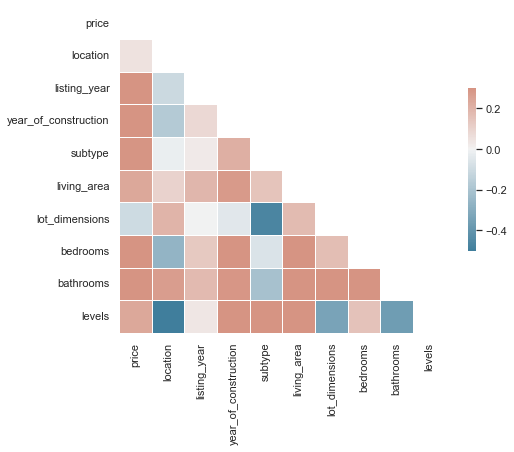

In [282]:
df = X_train.copy()
df.insert(0, 'price', y_train)
plot_corr_map(df)

In [283]:
reg = LinearRegression().fit(X_train, y_train)
reg.score(X_test, y_test)

0.529285784290862

# Neural Net

In [284]:
model = Sequential()
model.add(Dense(units=50, activation='sigmoid', input_shape=(X_train.shape[-1],)))
model.add(Dense(units=10, activation='sigmoid'))
model.add(Dense(units=1, activation='sigmoid'))

print(model.summary())

model.compile(optimizer=Adam(lr=0.001), loss='mse')

history = model.fit(X_train, y_train, batch_size=1000, epochs=500, shuffle=True, verbose=1, validation_data=(X_test, y_test))

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_33 (Dense)            (None, 50)                500       
                                                                 
 dense_34 (Dense)            (None, 10)                510       
                                                                 
 dense_35 (Dense)            (None, 1)                 11        
                                                                 
Total params: 1,021
Trainable params: 1,021
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/500


c:\Users\simon\Documents\GitHub\quebec-real-estate\venv\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


33/33 [==============================] - 0s 3ms/step - loss: 0.0487 - val_loss: 0.0286
Epoch 2/500
33/33 [==============================] - 0s 2ms/step - loss: 0.0251 - val_loss: 0.0220
Epoch 3/500
33/33 [==============================] - 0s 2ms/step - loss: 0.0239 - val_loss: 0.0216
Epoch 4/500
33/33 [==============================] - 0s 2ms/step - loss: 0.0234 - val_loss: 0.0212
Epoch 5/500
33/33 [==============================] - 0s 2ms/step - loss: 0.0227 - val_loss: 0.0204
Epoch 6/500
33/33 [==============================] - 0s 2ms/step - loss: 0.0219 - val_loss: 0.0195
Epoch 7/500
33/33 [==============================] - 0s 2ms/step - loss: 0.0209 - val_loss: 0.0187
Epoch 8/500
33/33 [==============================] - 0s 2ms/step - loss: 0.0197 - val_loss: 0.0176
Epoch 9/500
33/33 [==============================] - 0s 2ms/step - loss: 0.0184 - val_loss: 0.0164
Epoch 10/500
33/33 [==============================] - 0s 2ms/step - loss: 0.0168 - val_loss: 0.0148
Epoch 11/500
33/33 [=

In [285]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

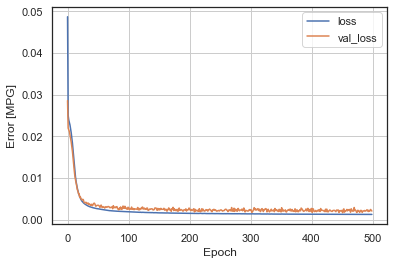

In [286]:
plot_loss(history)

In [287]:
sk_predicted_prices = target_scaler.inverse_transform(reg.predict(X_test))
nnet_predicted_prices = target_scaler.inverse_transform(model.predict(X_test))
real_prices = target_scaler.inverse_transform(y_test)

In [288]:
test_df = X_test.copy()

In [289]:
for col in scaled_cols:
    test_df[col] = scalers[col].inverse_transform(test_df[[col]])

for col in ordinal_cols:
    test_df[col] = ordinal_encoders[col].inverse_transform(test_df[[col]])

In [290]:
d = {}
d['real price'] = list(real_prices)
d['nnet predicted price'] = list(nnet_predicted_prices)
d['sk predicted price'] = list(sk_predicted_prices)

test_df['real price'] = d['real price']
test_df['nnet predicted price'] = d['nnet predicted price']
test_df['sk predicted price'] = d['sk predicted price']

test_df['real price'] = test_df['real price'].astype(int)
test_df['nnet predicted price'] = test_df['nnet predicted price'].astype(int)
test_df['sk predicted price'] = test_df['sk predicted price'].astype(int)

In [291]:
test_df.head(12)

,location,listing_year,year_of_construction,subtype,living_area,lot_dimensions,bedrooms,bathrooms,levels,real price,nnet predicted price,sk predicted price
17753,Portneuf,2021,1957,Bungalow,1261.0,9500.0,2.0,1.0,1.0,265000,283922,303632
46421,Gatineau,2021,1989,Semi-detached,2400.0,4471.0,4.0,2.0,2.0,360000,383147,464701
34470,Alma,2021,1989,2 Storey,1800.0,16090.0,5.0,2.0,2.0,284000,305419,399953
30573,Alma,2021,1989,2 Storey,1800.0,16090.0,5.0,2.0,2.0,284000,305419,399953
19019,Beaupré,2021,2016,Semi-detached,1560.0,3172.0,5.0,2.0,2.0,610000,650080,579416
23390,Gatineau,2021,1989,Semi-detached,2400.0,4471.0,4.0,2.0,2.0,360000,383147,464701
38461,Laval-sur-le-Lac,2021,1975,Bi-generation,1267.0,10100.0,4.0,2.0,1.0,550000,581481,434643
16400,Beaupré,2021,2016,Semi-detached,1560.0,3172.0,5.0,2.0,2.0,610000,650080,579416
17107,Stoneham,2021,2019,Bi-generation,2024.0,17000.0,4.0,3.0,1.0,526500,560141,569873
18187,Stoneham,2021,2019,Bi-generation,2024.0,17000.0,4.0,3.0,1.0,526500,560141,569873


In [292]:
errors = abs(nnet_predicted_prices - real_prices)
errors_small = list(filter(lambda x: x < 100000, errors))
errors_pct = 100 * (abs(nnet_predicted_prices - real_prices) / real_prices)
errors_pct_small = list(filter(lambda x: x < 100, errors_pct))

c:\Users\simon\Documents\GitHub\quebec-real-estate\venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

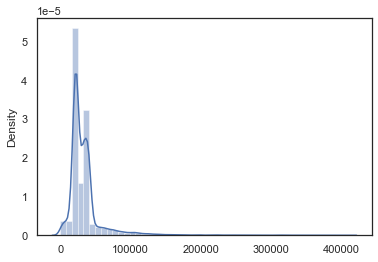

In [293]:
sns.distplot(errors)

c:\Users\simon\Documents\GitHub\quebec-real-estate\venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

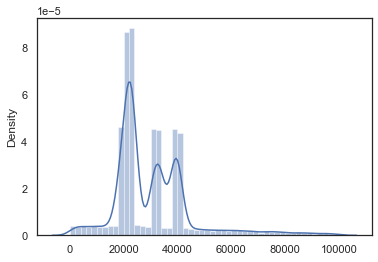

In [294]:
sns.distplot(errors_small)

c:\Users\simon\Documents\GitHub\quebec-real-estate\venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

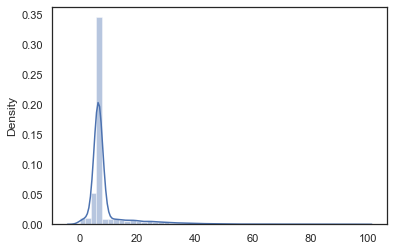

In [295]:
sns.distplot(errors_pct_small)

In [296]:
e_avg = int(np.mean(errors))
e_std = int(np.std(errors))
epct_avg = round(np.mean(errors_pct), 2)
epct_std = round(np.std(errors_pct), 2)

print('Error Mean ($): ' + str(e_avg) + '$')
print('Error std ($): ' + str(e_std) + '$')
print('Error Mean (%): ' + str(epct_avg) + '%')
print('Error std (%): ' + str(epct_std) + '%')

Error Mean ($): 33826$
Error std ($): 26393$
Error Mean (%): 9.8%
Error std (%): 11.63%
